<a href="https://colab.research.google.com/github/VasukiElsa/Chat2Visualization/blob/main/Chat2Visualiztion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install -q google-generativeai==0.3.1

In [75]:


import google.generativeai as genai
import sqlite3
import matplotlib.pyplot as plt
from collections import Counter



In [76]:
genai.__version__

'0.3.1'

In [77]:
from google.colab import userdata

genai.configure(api_key = userdata.get('GEMINI_KEY'))

In [78]:
# Set up the model
generation_config = {
  "temperature": 0.4,
  "top_p": 1,
  "top_k": 32,
  "max_output_tokens": 4096,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  }
]



In [79]:
model = genai.GenerativeModel(model_name = "gemini-pro",
                              generation_config = generation_config,
                              safety_settings = safety_settings)


In [80]:
def generate_gemini_response(question, input_prompt):
    prompt_parts = [input_prompt, question]
    response = model.generate_content(prompt_parts)
    return response.text

In [87]:
def generate_visualization(query, db):
    # Connect to the SQLite database
    conn = sqlite3.connect(db)
    c = conn.cursor()

    # Execute the SQL query and fetch the results
    c.execute(query)
    results = c.fetchall()

    # Close the database connection
    conn.close()

    # Determine the data structure and chart type
    data = {}
    if len(results[0]) == 1:
      data = {f"Result": results[0][0]}
      chart_type = 'pie'
    elif len(results[0]) == 2:  # Assuming two columns in the result
        data = Counter(row[0] for row in results)
        chart_type = 'pie'
    else:
        for row in results:
            key = row[0]
            value = row[1]
            data[key] = value
        chart_type = 'bar'
    prompt_parts_1 = [
  "You are an expert in converting English questions to SQL code! The SQL database has the name fashion_products and has the following columns - user_id, product_id, product_name, brand, category, price, color, and size.\n\nFor example,\nExample 1 - How many entries of Adidas are present?, the SQL command will be something like this\n``` SELECT COUNT(*) FROM fashion_products WHERE brand = 'Adidas';\n```\n\nExample 2 - How many XL products of Nike are there that have a rating of more than 4?\n```\nSELECT COUNT(*) FROM fashion_products WHERE brand = 'Nike' AND size = 'XL' AND \"Rating\" > 4;\n```\n\nExample 3 - \n```\nSELECT product_name FROM fashion_products WHERE price = (SELECT MAX(price) FROM fashion_products);\n\n Example 4 - Give me the details of most expensive T-shirt\n ``` SELECT * FROM fashion_products WHERE product_name = 'T-shirt' AND price = (SELCT MAX(price) FROM fashion_products WHERE product_name = 'T-shirt');\n```\n\n```Dont include ``` and \\n in the output",
]

    # Generate the chart description using the language model
    description_prompt = f"Based on the query '{query}', the data structure is {data}, and the appropriate chart type is {chart_type}. Provide a brief description of the chart."
    description = generate_gemini_response(description_prompt, prompt_parts_1[0])

    # Create the chart
    plt.figure(figsize=(10, 6))
    if chart_type == 'pie':
        plt.pie(data.values(), labels=data.keys(), autopct='%1.1f%%')
        plt.axis('equal')
    else:
        keys = list(data.keys())
        values = list(data.values())
        plt.bar(keys, values)
        plt.xlabel("X-Axis")
        plt.ylabel("Y-Axis")
        plt.xticks(rotation=45)

    plt.title(description)
    plt.tight_layout()
    plt.show()


**Sample user_inputs:**
Could you please show me all the details of the fashion products available?
What are the distinct product names and their prices?
How many products of each brand are there?
What are the most expensive products?
What is the average price of Zara products?


In [88]:
def visualize_user_query():
    user_input = input("Enter your question: ")
    prompt_parts_1 = [
  "You are an expert in converting English questions to SQL code! The SQL database has the name fashion_products and has the following columns - user_id, product_id, product_name, brand, category, price, color, and size.\n\nFor example,\nExample 1 - How many entries of Adidas are present?, the SQL command will be something like this\n``` SELECT COUNT(*) FROM fashion_products WHERE brand = 'Adidas';\n```\n\nExample 2 - How many XL products of Nike are there that have a rating of more than 4?\n```\nSELECT COUNT(*) FROM fashion_products WHERE brand = 'Nike' AND size = 'XL' AND \"Rating\" > 4;\n```\n\nExample 3 - \n```\nSELECT product_name FROM fashion_products WHERE price = (SELECT MAX(price) FROM fashion_products);\n\n Example 4 - Give me the details of most expensive T-shirt\n ``` SELECT * FROM fashion_products WHERE product_name = 'T-shirt' AND price = (SELCT MAX(price) FROM fashion_products WHERE product_name = 'T-shirt');\n```\n\n```Dont include ``` and \\n in the output",
]
    sql_query = generate_gemini_response(user_input, prompt_parts_1[0])
    generate_visualization(sql_query, "/content/drive/MyDrive/fashion_db.sqlite")

Enter your question: What are the distinct product names and their prices? 


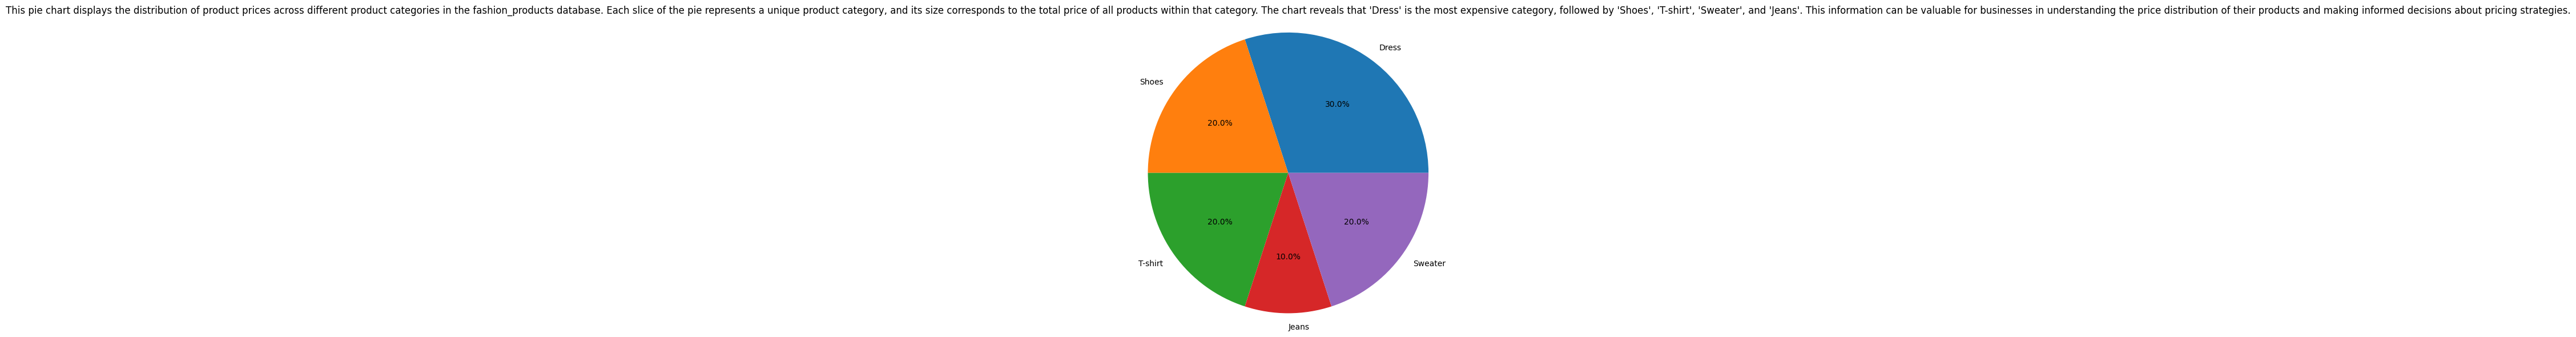

In [94]:
visualize_user_query()